<a href="https://colab.research.google.com/github/hmh10098/d2l/blob/main/7_4_GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.8 MB/s 


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p1_2 = nn.BatchNorm2d(c1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.BatchNorm2d(c2[0])
        self.p2_3 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p2_4 = nn.BatchNorm2d(c2[1])
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.BatchNorm2d(c3[0])
        self.p3_3 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p3_4 = nn.BatchNorm2d(c3[1])
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
        self.p4_3 = nn.BatchNorm2d(c4)

    def forward(self, x):
        p1 = F.relu(self.p1_2(self.p1_1(x)))
        p2 = F.relu(self.p2_4(self.p2_3(F.relu(self.p2_2(self.p2_1(x))))))
        p3 = F.relu(self.p3_4(self.p3_3(F.relu(self.p3_2(self.p3_1(x))))))
        p4 = F.relu(self.p4_3(self.p4_2(self.p4_1(x))))
        return torch.cat((p1, p2, p3, p4), dim=1)

In [17]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64),
                   nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2,
                                           padding=1))

In [18]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.BatchNorm2d(64), nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.BatchNorm2d(192), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [19]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [20]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [21]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

loss 0.083, train acc 0.969, test acc 0.910
1444.2 examples/sec on cuda:0


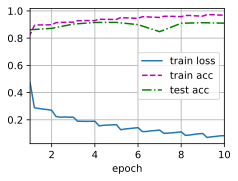

In [22]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [23]:
from torchsummary import summary
summary(net, (1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]           4,160
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 192, 24, 24]         110,784
       BatchNorm2d-9          [-1, 192, 24, 24]             384
             ReLU-10          [-1, 192, 24, 24]               0
        MaxPool2d-11          [-1, 192, 12, 12]               0
           Conv2d-12           [-1, 64, 12, 12]          12,352
      BatchNorm2d-13           [-1, 64, 12, 12]             128
           Conv2d-14           [-1, 96,